# Python-Oracle Anbindung

## Benötigte Pakete:

   
    - Oracle-Pandas: 'pip install pandas-oracle', https://github.com/cwade/pandas_oracle
    - cx_Oracle: wird über pandas-oracle installiert
    - Seaborn, Pandas, Numpy, etc 


## HU-VPN  aktivieren oder in HU-Netzwerk (WLAN) einloggen.

Anleitungen:
https://www.cms.hu-berlin.de/de/dl/netze/vpn


## Verbindungsdaten: 
Die Verbindungsdaten werden in config.yml gespeichert. Die Datein *muss* im gleichen Ordner liegen.

In [1]:
import pandas_oracle.tools as pt
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Verbindungsaufbau:

In [2]:
def run_query(query) :
    ## opening conn
    conn = pt.open_connection("config.yml")

    try:
        ## passing the conn object to the query_to_df
        df1 = pt.query_to_df(query, conn, 10000)
        return df1
    except Exception as e:
        print("An exception occurred")
        print(str(e))
    finally:
        ## close connection
        pt.close_connection(conn)

*Wichtig: die Verbindungs zur DB muss geschlossen werden, wenn ein Fehler auftritt.*

# 1. Beispielanfrage

In [3]:
query = "select * from airport"
df = run_query(query)
df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,EGE,Eagle County Regional Airport,Eagle,CO,USA,3964257.0,-10691770.0
1,EKO,Elko Regional Airport,Elko,NV,USA,4082493.0,-11579170.0
2,ELM,Elmira/Corning Regional Airport,Elmira,NY,USA,4215991.0,-7689144.0
3,ELP,El Paso International Airport,El Paso,TX,USA,3180667.0,-10637781.0
4,ERI,Erie International Airport,Erie,PA,USA,4208202.0,-8017622.0
...,...,...,...,...,...,...,...
317,EAU,Chippewa Valley Regional Airport,Eau Claire,WI,USA,4486526.0,-9148507.0
318,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
319,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
320,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


## Visualisierung

In [4]:
df.columns

Index(['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')

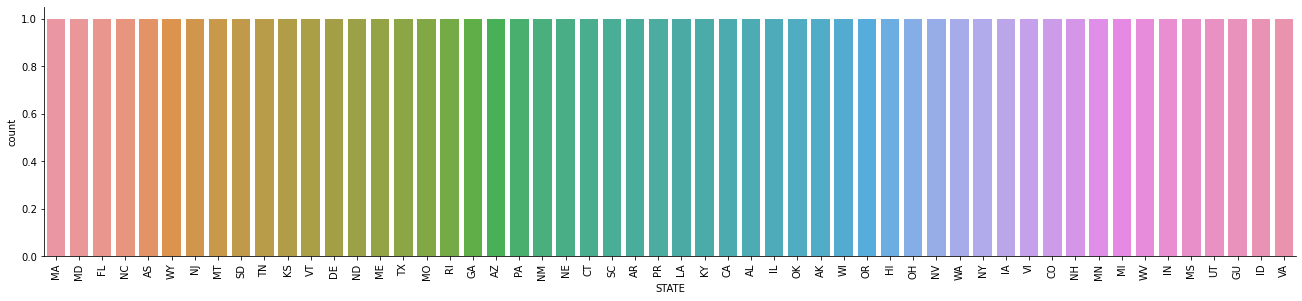

In [15]:
# Vorsicht: hier wird aggregiert. Das wollen wir aber selbst in SQL machen!
# Siehe nächste Anfrage
g=sns.catplot(x='STATE',
            kind='count',
            height=4, 
            aspect=4.5,
            data=df,
            order=df['STATE'].value_counts().index)
_=g.set_xticklabels(rotation=90)

In [7]:
query2 = "select state, count(*) as anz from airport GROUP BY STATE"
df = run_query(query2)
df

,STATE,ANZ
0,NJ,3
1,AK,19
2,SD,3
3,MN,8
4,OK,3
5,AS,1
6,WV,1
7,ND,8
8,CA,22
9,WY,6


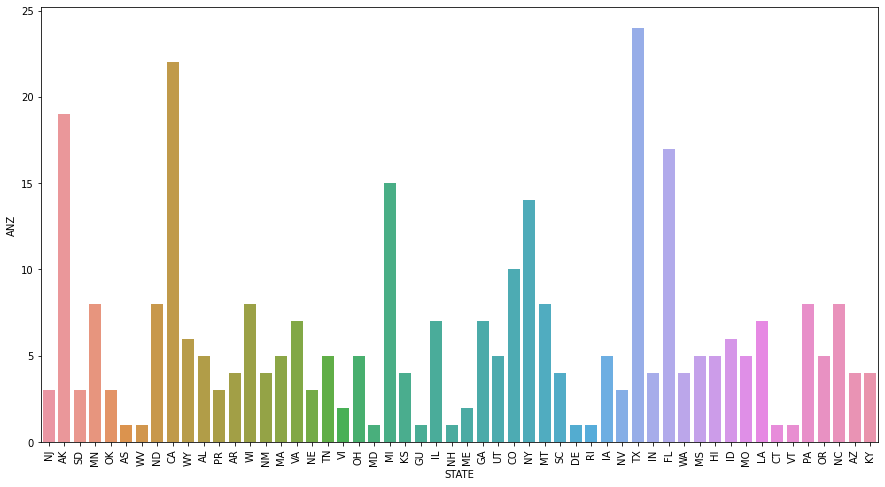

In [8]:
plt.figure(figsize=(15,8))
g=sns.barplot(x='STATE',
            y='ANZ',
            data=df)
_=g.set_xticklabels(df['STATE'], rotation=90)


# Aufgaben

In [9]:
#Aufgabe 1
delayReasonsQuery = "select sum(air_system_delay), sum(security_delay),\
                            sum(airline_delay), sum(late_aircraft_delay),\
                            sum(weather_delay)\
                     from   delays"

delaySums = run_query(delayReasonsQuery)
delaySums

,SUM(AIR_SYSTEM_DELAY),SUM(SECURITY_DELAY),SUM(AIRLINE_DELAY),SUM(LATE_AIRCRAFT_DELAY),SUM(WEATHER_DELAY)
0,13533065,77945,18966945,23767674,2991008


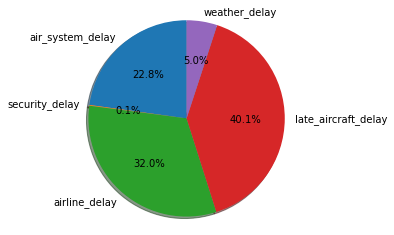

In [10]:
labels = 'air_system_delay', 'security_delay', 'airline_delay',\
         'late_aircraft_delay', 'weather_delay'

sizes = delaySums.iloc[0].astype(int).values.tolist()


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [11]:
#Aufgabe 2
#most delays in states
StateDelayQuery = "select avg(departure_delay), origin_state\
                   from delays, flight\
                   where delays.FLIGHT_ID = flight.FLIGHT_ID\
                   group by origin_state"
StateDelay = run_query(StateDelayQuery)
StateDelay.sort_values(by=["AVG(DEPARTURE_DELAY)"], ascending = False).head()

,AVG(DEPARTURE_DELAY),ORIGIN_STATE
36,29.391753,DE
29,16.647590,GU
6,15.102804,AS
24,13.642984,IL
1,13.535258,NJ


In [ ]:
#CREATE INDEX IDX_DFLIGHT_ID ON delays(FLIGHT_ID))
#CREATE INDEX IDX_FFLIGHT_ID ON flight(FLIGHT_ID))

In [14]:
#most delays at airports
AirportDelayQuery = "select avg(departure_delay), origin_airport \
                     from delays, airport\
                     where delays.ORIGIN_AIRPORT = airport.IATA_CODE\
                     group by origin_airport"
AirportDelay = run_query(AirportDelayQuery)
AirportDelay.sort_values(by=["AVG(DEPARTURE_DELAY)"], ascending = False).head()
AirportDelay

,AVG(DEPARTURE_DELAY),ORIGIN_AIRPORT
0,2.873297,CLL
1,8.041528,SMF
2,10.216277,AUS
3,12.075269,PBG
4,12.376126,BQN
...,...,...
317,11.518694,CRW
318,15.744398,EGE
319,11.210016,PHF
320,8.555016,MKG


In [ ]:
#CREATE INDEX IDX_airport ON delays(ORIGIN_AIRPORT))
#CREATE INDEX IDX_iata ON airport(IATA_CODE))

In [16]:
AirlineWithMostFlightsQuery = "select   count(flight_ID), airline_iata\
                               from     delays\
                               group by airline_iata"

AirlineWithMostFlights = run_query(AirlineWithMostFlightsQuery)
AirlineWithMostFlights

,COUNT(FLIGHT_ID),AIRLINE_IATA
0,526249,EV
1,158054,AS
2,648694,AA
3,198715,US
4,82735,F9
5,56439,VX
6,1157339,WN
7,800329,DL
8,245135,B6
9,70030,HA


In [ ]:
#CREATE INDEX SUMS ON delays(count(flight_ID))

In [17]:
AirlineWithMostDelayQuery = "select   avg(departure_delay), airline_iata\
                             from     delays\
                             group by airline_iata"

AirlineWithMostDelay = run_query(AirlineWithMostDelayQuery)
AirlineWithMostDelay.sort_values(by=["AVG(DEPARTURE_DELAY)"], ascending= False)

,AVG(DEPARTURE_DELAY),AIRLINE_IATA
13,16.683317,NK
12,15.131718,UA
4,14.267977,F9
8,11.828654,B6
6,10.995318,WN
10,10.685483,MQ
2,9.330882,AA
5,9.211211,VX
0,9.076964,EV
11,8.181225,OO


In [ ]:
#CREATE INDEX SUMS ON delays(avg(departure_delay))